# ***Alexanda Apostolopoulou***
# ***1115201700005***
# *Project 4 in AI (II)* 

In [1]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time

## ***Step 1:*** Download SQuAD 2.0 dataset and Tranformers library

The ***Stanford Question Answering Dataset*** (SQuAD) consists of questions (100,000)  on a set of Wikipedia articles where the answer to every question is a segment of text, or span, from the corresponding reading passage. In second version of SQuAD unanswerable questions were added (50,000) to look similar to answerable ones.  

The purpose of systems using the SQuAD2.0 dataset, must be not only answer questions when possible, but also determine when no answer is supported by the paragraph and abstain from answering. 

In [2]:
# %%capture
# !mkdir squad
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

In [3]:
%%capture
!pip install transformers

## ***Step 2:*** Retrieve and Store the data

Here I take and store the texts, queries and answers from the train and validation .json files. If we look carefully we will see that in these files there are a number of queries and answers for each passage. I save these informations into lists.

In [4]:
# Give the path for train data
path = Path('squad/train-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Store every passage, query and its answer to the lists
                texts.append(context)
                queries.append(question)
                answers.append(answer)

train_texts, train_queries, train_answers = texts, queries, answers

In [5]:
# Give the path for validation data
path = Path('squad/dev-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Store every passage, query and its answer to the lists
                texts.append(context)
                queries.append(question)
                answers.append(answer)

val_texts, val_queries, val_answers = texts, queries, answers

## ***Step 3:*** Check the data

As you can see we have 86821 passages, queries and answers from the training data. The answer is stored in a dictionary with the specific answer in the "text" cell and the accurate character index that the answer is started in cell "answer start". As we observe, is missing the information about the exact index of the character that the answer is ending.

In [6]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

86821
86821
86821


In [7]:
print("Passage: ",train_texts[0])  
print("Query: ",train_queries[0])
print("Answer: ",train_answers[0])

Passage:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query:  When did Beyonce start becoming popular?
Answer:  {'text': 'in the late 1990s', 'answer_start': 269}


As you can see we have 20302 passages, queries and answers from the validation data

In [8]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

20302
20302
20302


In [9]:
print("Passage: ",val_texts[0])  
print("Query: ",val_queries[0])
print("Answer: ",val_answers[0])

Passage:  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Query:  In what country is Normandy located?
Answer:  {'text': 'France', 'answer_start': 159}


This was helped me to split my dataset in order to run my notebook in my first attemps.

In [30]:
train_texts = train_texts[:10]
train_queries = train_queries[:10]
train_answers = train_answers[:10]

val_texts = val_texts[:10]
val_queries = val_queries[:10]
val_answers = val_answers[:10]

In [11]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

In [47]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

10
10
10


In [48]:
val_answers

[{'text': 'France', 'answer_start': 159, 'answer_end': 165},
 {'text': 'France', 'answer_start': 159, 'answer_end': 165},
 {'text': 'France', 'answer_start': 159, 'answer_end': 165},
 {'text': 'France', 'answer_start': 159, 'answer_end': 165},
 {'text': '10th and 11th centuries', 'answer_start': 94, 'answer_end': 117},
 {'text': 'in the 10th and 11th centuries',
  'answer_start': 87,
  'answer_end': 117},
 {'text': '10th and 11th centuries', 'answer_start': 94, 'answer_end': 117},
 {'text': '10th and 11th centuries', 'answer_start': 94, 'answer_end': 117},
 {'text': 'Denmark, Iceland and Norway',
  'answer_start': 256,
  'answer_end': 283},
 {'text': 'Denmark, Iceland and Norway',
  'answer_start': 256,
  'answer_end': 283}]

## ***Step 4:*** Find the end position character

Because Bert model needs both start and end position characters of the answer, I have to find it and store it for later. Sometimes, I notice that SQuAD anwers "eat" one or two characters from the real answer in the passage. For example, (as a colleague said in Piazza) for the word "sixth" in passage, SQuAD give the answer of "six". So in these cases I select to handle this problem by "cutting" the passage by 1 or 2 characters to be the same as the given answer. This strategy is because BERT works with ***tokens*** of a specific format so I needed to process the squad dataset to keep up with the input that BERT is waiting for. 

Find end position character in train data

In [31]:
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters 
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1  
    # When the real answer is more by two characters  
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2    

Find end position character in validation data

In [32]:
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters 
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1  
    # When the real answer is more by two characters  
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2   

In [49]:
val_queries

['In what country is Normandy located?',
 'In what country is Normandy located?',
 'In what country is Normandy located?',
 'In what country is Normandy located?',
 'When were the Normans in Normandy?',
 'When were the Normans in Normandy?',
 'When were the Normans in Normandy?',
 'When were the Normans in Normandy?',
 'From which countries did the Norse originate?',
 'From which countries did the Norse originate?']

## ***Step 5:*** Tokenize passages and queries

In this task is asked to select the BERT-base pretrained model “bert-base-uncased” for the tokenization

In [33]:
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

## ***Step 6:*** Convert the start-end positions to tokens start-end positions 

In [34]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []

  count = 0

  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
      
    # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      # if end position is still None the answer passage has been truncated
      if end_positions[-1] is None:
        count += 1
        end_positions[-1] = tokenizer.model_max_length

  print(count)

  # Update the data in dictionary
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

0
0


I observed that after tokenize the end position character, sometimes was still None. This happended only for 10 answers in train data (of total 86821) and 16 answers in validation data (of total 20302). So I decided to move the answer 1 position left. If it was still None then I give them the model_max_length as before. I have to refer that I was trying to see if the answers in this case was 1 postition after (so I added +1 to the end position) or 2 positions left or right (+/- 2 positions), but the answers that there are still None was more (ie 526, while with this code there only 10). So I kept this strategy in the end, in order to have as less as possible "burned" answers.

## ***Step 7:*** Create a Dataset class 

Create a Squatdataset class (inherits from torch.utils.data.Dataset), that helped me to train and validate my previous data more easily and convert encodings to datasets.

In [35]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [36]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

## ***Step 8:*** Use of DataLoader

I put my previous data to DataLoader, so as to split them in "pieces" of 8 batch size. I will explain the selection of this value of batch size later.

In [37]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

## ***Step 9:*** Use GPU

In [42]:
device = torch.device(
    'cuda:0' if torch.cuda.is_available() 
    # else ('mps' if torch.backends.mps.is_available() 
          else 'cpu' 
         # ) 
)
device


device(type='cpu')

## ***Step 10:*** Build the Bert model

I select BertForQuestionAnswering from transformers library, as it was the most relative with this task. When we instantiate a model with from_pretrained(), the model configuration and pre-trained weights of the specified model are used to initialize the model. Moreover, I used the PyTorch optimizer of AdamW which implements gradient bias correction as well as weight decay.



In [23]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

optim = AdamW(model.parameters(), lr=5e-5)
# optim = AdamW(model.parameters(), lr=3e-5)
# optim = AdamW(model.parameters(), lr=2e-5)

# epochs = 2
epochs = 3
# epochs = 4

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/hims/anaconda3/envs/python310/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


This message is a warning that I should fine tune my model before I test it, in order to have a good performance.

## ***Step 11:*** Train and Evaluate Model

Training of model was done exactly as in the previous projects.

In [43]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

for epoch in range(epochs):
  epoch_time = time.time()

  # Set model in train mode
  model.train()
    
  loss_of_epoch = 0

  print("############Train############")

  for batch_idx,batch in enumerate(train_loader): 
    print(batch_idx)
    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # do a backwards pass 
    loss.backward()
    # update the weights
    optim.step()
    # Find the total loss
    loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
      print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch)

  ##########Evaluation##################

  # Set model in evaluation mode
  model.eval()

  print("############Evaluate############")

  loss_of_epoch = 0

  for batch_idx,batch in enumerate(val_loader):
    
    with torch.no_grad():

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)
      
      outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
      loss = outputs[0]
      # Find the total loss
      loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
       print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(val_loader)
  val_losses.append(loss_of_epoch)

  # Print each epoch's time and train/val loss 
  print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
0
############Evaluate############

-------Epoch  1 -------
Training Loss: 4.177757263183594 
Validation Loss: 4.019200325012207 
Time:  3.3065388202667236 
----------------------- 


############Train############
0
############Evaluate############

-------Epoch  2 -------
Training Loss: 4.0387492179870605 
Validation Loss: 3.997199535369873 
Time:  2.4417529106140137 
----------------------- 


############Train############
0
############Evaluate############

-------Epoch  3 -------
Training Loss: 3.8154025077819824 
Validation Loss: 3.9653711318969727 
Time:  2.450193166732788 
----------------------- 


Total training and evaluation time:  8.199166059494019


In [44]:
# Save model
torch.save(model,"squad/finetunedmodel")

## ***Step 12:*** Plot train and validation losses

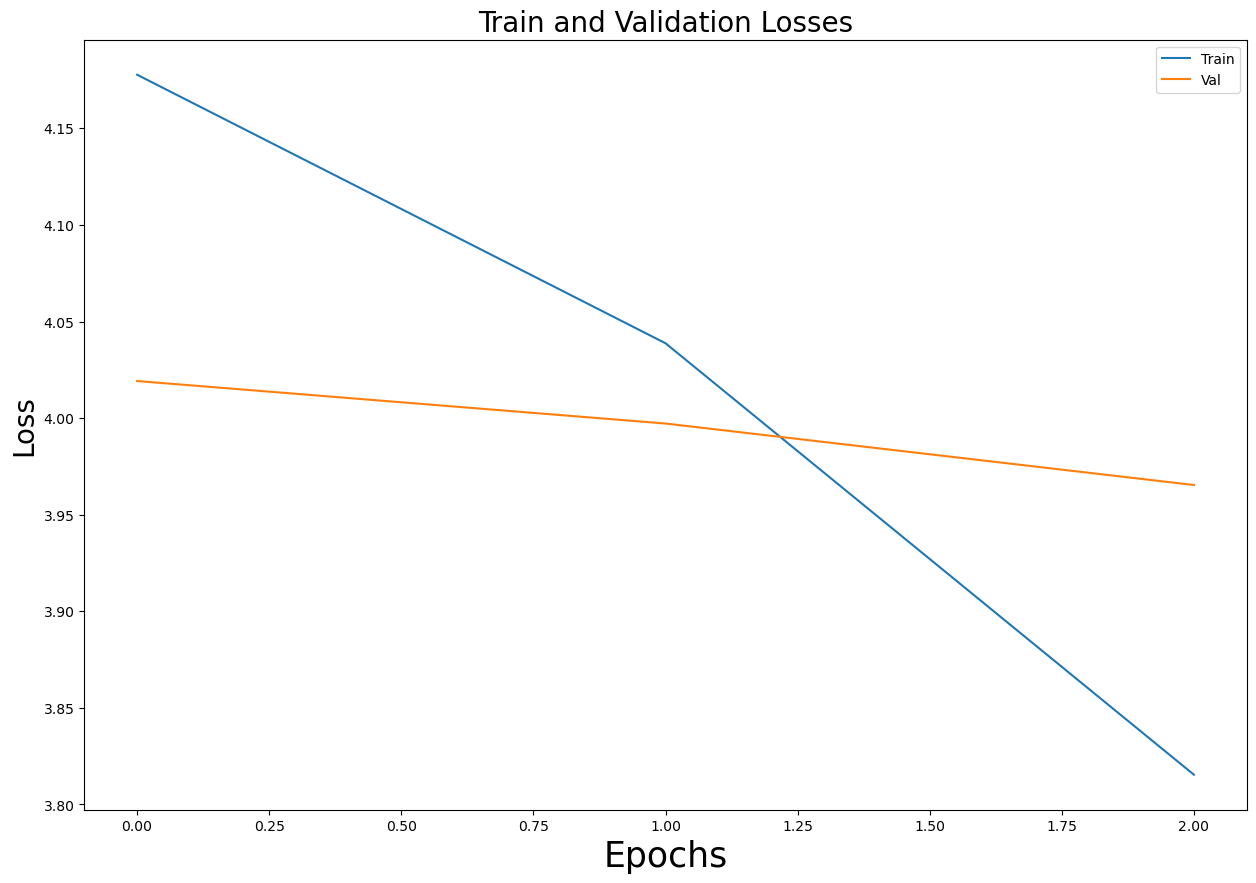

In [45]:
import matplotlib.pyplot as plt 

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

## ***Step 13:*** Summaries

- I have to mention that I waited several hours to run all the notebook (sometimes ~9 hours) and it was a very tiring and frustrating process, because sometimes after i.e 8 hours my google accound connection was disconnected or my gpu is run out. So, what I was left with from the whole process, is that it is very time consuming to train the model and it needs a strong computing power. 
- Nevertheless, I manage to run it for some hyperparameters that I want in order to take the best performance I could. I consulted the lectures of BERT for the values I want to try. More specifically:
  - ***Batch size:*** 8, 16
  - ***Learning rate (Adam):***  5e−5, 3e−5, 2e−5
  - ***Number of epochs:***  2, 3, 4

  I will analyze it more later, but in the end I kept the values of ***8 batch size***, ***3 epochs*** and ***5e-5 learning rate*** for optimal hyperparameters. 

- Concerning the ***number of epochs*** I began with 2 and I realize that overfitting happened from the very first epoch. So I understand that there isn't a reason to try much more epochs. When I tried sometimes to train my model for 4 epochs, the connection and cuda never let me, so I train my model with only 3 epochs. Moreover, it doesn't matter so much, as overfitting happened in the first epoch and the gap between the training and validation loss was getting bigger and bigger as the epochs increased.
- As for ***learning rate***, I tried all of these three values, and nothing changed for overfitting, so I kept the value of 5e-5, as the its perform was a little better (overfitting started from later epoch). Ι show a picture bellow of the learning curves of 3e-5 learning rate to see by yourself that there isn't difference.
- As for ***batch size***, it was impossible to train my model with bigger batch size and I believe that this is the reason that my model overfits from the very first epoch. The smaller batch size is the better and faster the model learn in data, so the training loss decreased very quick. On the other hand, any number I tried bigger than 8 in batch size (16, 32, 64), Ram Memory ran out instantaneously. Intuitively and empirically, from previous Projects, if we had bigger batch size the model would learn in data more slowly, but the learning curves would be more smoother and we could handle with overfitting. But this is something that couldn't happen, bacause of memory limit usage of Google Colab.
- I tried to faced up with overfitting with other ways, but in vain.
 - I tried to add a bigger dropout probability (with a dropout layer), because I notice that in Bert model the dropout probability was always kept at 0.1, but nothing changed.
 - I tried to reduce the amount of data in half (40.000), but overfitting still happened and actually led to worse performance in general.
 - In the end, I understand that our Bert model is already pretty complex and the fact that we give it more data it does it more complex.
- I have to mention that I select the fine tuning technique that trains the entire architecture with the error to be the back-propagated through the entire architecture and the pre-trained weights of the model are updated based on the new dataset. I was more familiar with this technique from previous Projects and not with freezing all or some of the layers of architecture. Futhermore, QA tasks are very complicated and I believe that it is important to have the information of all layers.

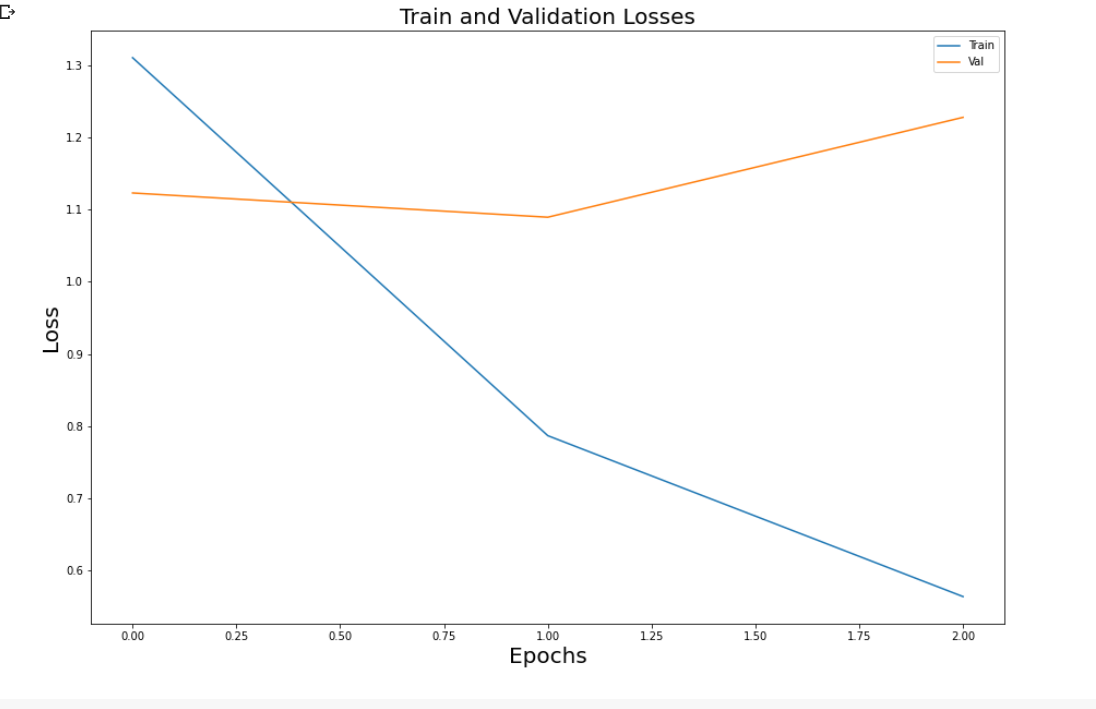